<b> Import Library, find available devices </b>

In [1]:
# Initialization code for 3.3 V SiGe LVR Load Regulation Testing.
# This block identifies and initializes the connected SMUs (Source Measure Units).
# If running for the first time, ensure the SMU names are correctly referenced in the subsequent code block.

# This program sweeps VIN for a fixed VREF and measures total quiescent current (IQ) and VOUT. 
# This program sets up a directory for all measurements taken at a specific temperature by prompting the user for the temperature.
# This program creates a .csv file to save the measurements for a VREF in the temperature directory. 

# The setup assumes the use of two SMUs:
# - One dedicated to VIN sweeps.
# - One Sinks a load current and measures VOUT.

import pyvisa                    # Importing the pyvisa library for instrument communication
import time                      # Importing the time module to handle time-related tasks (e.g., delays)
import matplotlib.pyplot as plt  # Importing matplotlib.pyplot for plotting graphs and visualizing data
import numpy as np               # Importing numpy for numerical operations, particularly with arrays
import pandas as dp              # Importing pandas as dp for data manipulation and analysis
import os                        # Importing os to interact with the operating system, such as handling file paths
import csv                       # Importing csv to read from and write to CSV files
from datetime import date           # Importing date to read current date
from collections import defaultdict
rm = pyvisa.ResourceManager()    # Create a ResourceManager object, which manages communication with instruments
rm.list_resources()              # List all available resources (e.g., connected instruments) managed by pyvisa

('USB0::0x2A8D::0x0101::MY54505624::INSTR',
 'USB0::0x0957::0x5707::MY53802060::INSTR',
 'USB0::0x2A8D::0x0101::MY57508183::INSTR',
 'GPIB6::6::INSTR',
 'GPIB6::20::INSTR',
 'USB0::0x0957::0x0607::MY45002108::0::INSTR',
 'USB0::0x0957::0x1796::MY57231548::0::INSTR',
 'USB0::0x0957::0x1796::MY57231553::0::INSTR',
 'USB0::0x0957::0x17B6::MY56310504::0::INSTR',
 'USB0::0x0957::0x2C07::MY57890777::0::INSTR')

In [2]:
#Establishing Connection for VIN SMU
SM_VIN = rm.open_resource('GPIB6::20::INSTR')  # Open a connection to the instrument with the address 'ASRL3::INSTR' and assign it to SM_VIN
SM_VIN.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
SM_VIN.write_termination = '\n'            # Set the write termination character to a newline. This ensures that each command sent to the instrument is properly terminated.
SM_VIN.baud_rate = 9600                    # Set the baud rate for serial communication to 9600. This is the speed at which data is transmitted over the serial connection.
print(SM_VIN)                              # Print the resource object (SM_VIN) to display its properties
print(SM_VIN.query('*IDN?'))               # Send the '*IDN?' command to the instrument and print its response. This command usually asks the instrument to identify itself (e.g., manufacturer, model number).


#Establishing Connection for VOUT multimeter
MM_VOUT = rm.open_resource('USB0::10893::257::MY57508183::0::INSTR')
MM_VOUT.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM_VOUT.write_termination = '\n'
MM_VOUT.baud_rate = 9600
print(MM_VOUT)                             # Print the resource object (SM_VOUT) to display its properties
print(MM_VOUT.query('*IDN?'))

#Establishing Connection for multimeter 1
MM_VDROP = rm.open_resource('USB0::0x2A8D::0x0101::MY54505624::INSTR')
MM_VDROP.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
MM_VDROP.write_termination = '\n'
MM_VDROP.baud_rate = 9600
print(MM_VDROP)                             # Print the resource object (SM_VOUT) to display its properties
print(MM_VDROP.query('*IDN?'))              

#Establishing Connection for VREF waveform generator
WG = rm.open_resource('USB0::2391::22279::MY53802060::0::INSTR')
WG.read_termination = '\n'             # Set the read termination character to a newline. This tells pyvisa when to consider a message as complete when reading from the instrument.
WG.write_termination = '\n'
WG.baud_rate = 9600
print(WG)                             # Print the resource object (SM_VOUT) to display its properties
print(WG.query('*IDN?'))

#Establishing Connection for Temperature Chamber
CHAMBER = rm.open_resource('GPIB6::6::INSTR') 
CHAMBER.read_termination = '\n'            
CHAMBER.write_termination = '\n'           
CHAMBER.baud_rate = 9600                  
print(CHAMBER)                            
print(CHAMBER.query('STATUS?'))              


VIN_MAX=33
VIN_STEP=1
VIN_MIN=11
ILMAX=-.01
VIN=[]
ITOT=[]
VOUT=[]
ILset=.003      # This is the load current to aim for
Rhi=499
Rlo=68000

VREFdef = 2

#ILlist=[-.00001, -.00003, -.00005, -.0001, -.0003, -.0005, -.001, -.003, -.005, -.01]
VREFlist = [0.8, 1.2, 1.6, 2.0, 2.4]
TEMPlist = [125, 100, 75, 50, 25,  0, -25, -50, -75, -100, -125, -150, -175]      # List of temperatures for test

GPIBInstrument at GPIB6::20::INSTR
KEITHLEY INSTRUMENTS INC.,MODEL 2401,4636506,B02 Jan 20 2021 10:19:49/B01  /W/N
USBInstrument at USB0::10893::257::MY57508183::0::INSTR
Keysight Technologies,34465A,MY57508183,A.02.17-02.40-02.17-00.52-04-01
USBInstrument at USB0::0x2A8D::0x0101::MY54505624::0::INSTR
Keysight Technologies,34465A,MY54505624,A.02.14-02.40-02.14-00.49-02-01
USBInstrument at USB0::2391::22279::MY53802060::0::INSTR
Agilent Technologies,33622A,MY53802060,A.01.11-2.25-03-64-02
GPIBInstrument at GPIB6::6::INSTR
YNNNNNYYNNNNNNNNNN0


<b> Initialize Source Meter (VIN) <b>

In [ ]:
SM_VIN.write(":CONF:CURR")                  # Configure the SMU to measure current
SM_VIN.write("OUTP:STAT 0")                 # Turn off the VIN source meter
print(SM_VIN.query(":CONF?"))               # Query and print the current configuration of the SMU
SM_VIN.write("SOUR:VOLT:RANG 3.3")
SM_VIN.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
SM_VIN.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
SM_VIN.write("CURR:NPLC 10")                # Set the number of power line cycles (NPLC) for the current measurement to 10. 
                                            # This controls the integration time, with higher values leading to more accurate but slower measurements.

<b> Initialize Waveform Generator <b>

In [ ]:
##### Waveform generator is used to output VREF #####
WG.write("OUTP1:LOAD DEF")          # Sets the output load to infinite so no impedance matching is necessary
WG.write("OUTP2:LOAD DEF")
WG.write("SOUR1:APPL:DC")          # Sets the Waveform generator to output a DC voltage
WG.write("SOUR2:APPL:DC")          # Sets the Waveform generator to output a DC voltage

<b> Initialize Multi Meter <b>

In [ ]:
MM_VOUT.write(":CONF:VOLT:DC")
MM_VOUT.write("VOLT:DC:RANG 10")
print(MM_VOUT.query(":CONF?"))
print(MM_VOUT.query(":READ?"))

<b> Initialize Temperature Chamber <b>

In [ ]:
CHAMBER.write("ON")
CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
CHAMBER.write("HON")                # Turns heat on
CHAMBER.write("CON")                # Turns cool on
time.sleep(1) 

print(CHAMBER.query("RATE?"))
print(CHAMBER.query("WAIT?"))

<b> Test Sweep Definitions </b>

In [3]:
def Chamber_INIT():
    CHAMBER.write("ON")
    CHAMBER.write("RATE=20")            # Sets the speed at which the chamber will ramp to change TEMP
    CHAMBER.write("WAIT=30")            # Sets the time that the chamber will wait once the desired temperature is reached before measurements start
    CHAMBER.write("HON")                # Turns heat on
    CHAMBER.write("CON")                # Turns cool on
    CHAMBER.write("PIDA=3")
    time.sleep(1) 

    print(CHAMBER.query("RATE?"))
    print(CHAMBER.query("WAIT?"))
    return

def SMU_On():
    SM_VIN.write(":SOUR:VOLT:MODE FIX")
    SM_VIN.write("SOUR:VOLT:LEV 0")
    SM_VIN.write("OUTP ON")
    return

def SMU_INIT():
    SM_VIN.write(":CONF:CURR")                  # Configure the SMU to measure current
    SM_VIN.write("OUTP:STAT 0")                 # Turn off the VIN source meter
    SM_VIN.write("SOUR:VOLT:RANG 3.3")
    SM_VIN.write("SENS:CURR:PROT:LEV 0.0105")   # Set the current protection level (compliance) to 10.5 mA. This limits the maximum current to protect the device under test.
    SM_VIN.write("SENS:CURR:RANG 1E-2")         # Set the current measurement range to 10 mA. This sets the expected maximum current for accurate measurement.
    SM_VIN.write("CURR:NPLC 10")
    return

def MMs_INIT():
    MM_VOUT.write(":CONF:VOLT:DC")
    MM_VOUT.write("VOLT:DC:RANG 10")
    MM_VDROP.write(":CONF:VOLT:DC")
    MM_VDROP.write("VOLT:DC:RANG 10")
    return

def turn_on():
    WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREFdef))                           # Sets VREF to default value
    #TODO: TURN ON VREF BEFORE VIN?
    SM_VIN.write("SOUR:VOLT:LEV 3.3")                      # Set VIN source value
    SM_VIN.write("OUTP:STAT 1")                                     # Turn on the VIN source meter output
    time.sleep(.5)
    VISET= -Rhi*(ILset-VREFdef/Rlo) + VREFdef
    WG.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))                       # Turn on the WG for VISET to set IL to 3mA for the first VREF so that it can warm up while CHAMBER starts
    return

def turn_off():
    WG.write("SOUR2:APPL:DC DEF, DEF, 0")                                    # Turn off VISET first!!!
    time.sleep(.5)
    SM_VIN.write("OUTP:STAT 0")                                  # Turn off the VIN source meter
    WG.write("OUTP1:STAT 0")                                    # Turn off VREF
    return

def VREF_Sweep(local, TEMP, LRplot):
    VISETlist=[]
    VDOlist=[]
    VOUTreglist=[]
    for VREF in VREFlist:                                       # Sets VREF constant throughout test
        ####### SETS VREF #######
        VISET= -Rhi*(ILset-VREF/Rlo) + VREF
        VISETlist.append(VISET)
        WG.write("SOUR2:APPL:DC DEF, DEF, " +str(VISET))                   # Sets VISET to need value to achieve 3mA of load current
                                                                    # Set VISET before VREF because VREF is being swept up. Want to limit current
        time.sleep(.1)
        WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREF))         # Sets VREF
        VDO, VOUTreg, VIN, VOUT = VIN_Sweep(VREF, local)                                # Calls the VIN_Sweep function that sweeps VIN
        LRplot[VREF].plot(VIN,VOUT, label="T=" + str(TEMP) + " °C")
        VDOlist.append(VDO)
        VOUTreglist.append(VOUTreg)                                 
    # And the end of the sweep, set VREF back to 2.4
    WG.write("SOUR1:APPL:DC DEF, DEF, " + str(VREFdef))
    VISET= -Rhi*(ILset-VREFdef/Rlo) + VREFdef
    WG.write("SOUR2:APPL:DC DEF, DEF," + str(VISET))

    # Create an excel file with info on each VISET value used per VREF
    df2 = dp.DataFrame({'VREF': VREFlist, 'VISET': VISETlist})
    csv_path=os.path.join(local, "VISET")                          # Generate the file path for saving the CSV
    df2.to_csv(csv_path, index=False)

    return(VDOlist, VOUTreglist)

def VIN_Sweep(VREF, local):
    ####### Creates Lists for Data #######
    SHEET="VREF="+str(VREF)+".csv"                          # Create a CSV file name based on the VREF value
    VIN=[]                                                  # Initialize an empty list to store VIN values
    ITOT=[]                                                 # Initialize an empty list to store total current values (IQ + IL)
    VOUT=[]                                                 # Initialize an empty list to store VOUT values
    VDROP=[]


    ##################### Sweep of VIN for IL=3mA #####################
    # VIN starts high at 3.3V and then sweeps down to 1V or VREF, whichever is higher.                                        
    # Note: IL should already be at -10mA (ILMAX) so no changes are needed to VIN SENS range or VOUT SOURCE value
    if VIN_MIN < VREF*10:                                   # Checks if the VIN_MIN value set in the first code block is less than VREF
        new_MIN = VREF*10 - 1                               # If yes: set the new minimum to be VREF instead of VIN_MIN
    else: new_MIN = VIN_MIN                                 # If no: continue using VIN_MIN

    for i in range (VIN_MAX,int(new_MIN),-VIN_STEP):        # Loop from VIN_MAX to VIN_MIN in steps of VIN_STEP                                                            
        val = i / 10                                        # Convert the current loop index into a floating-point voltage value
        ############ Sets VIN voltage ############                
        SM_VIN.write("SOUR:VOLT:LEV " + str(val))          # Write the command to set the VIN voltage on the source meter
        time.sleep(.1)                                               # Pause for .5 seconds to allow the system to stabilize
        
        ######## Measure ILOAD and others ########
        VOUT.append(float(MM_VOUT.query(":READ?")))     
        ITOT.append(SM_VIN.query(":READ?").split(',')[1])             # Query and append the measured total current through VIN
        VDROP.append(float(MM_VDROP.query(":READ?")))
        VIN.append(val)                                        # Append the current VIN value to the VIN list
    SM_VIN.write("SOUR:VOLT:LEV 3.3") 

    # Create a DataFrame with the collected data
    df = dp.DataFrame({'VIN': VIN, 'ITOT': ITOT, 'VOUT': VOUT, 'VDROP': VDROP})      # Create a pandas DataFrame from VIN, ITOT, and VOUT lists
    csv_path=os.path.join(local, SHEET)                          # Generate the file path for saving the CSV
    df.to_csv(csv_path, index=False)                             # Save the DataFrame to a CSV file without including the index
    
    VDO=VIN[-1]-VOUT[-1]                                        # Calculate Dropout Voltage, to be used to generate plot
    return(VDO, VOUT[0], VIN, VOUT)

<b> Test Protocol </b>

+20.000
00:30:00
YNNNYYYNYNNNNNNNNN0
YNNNYYYNYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNYYYYYNNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYYNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNNNYYYYNNNNNNNNNN0
YNN

TypeError: VREF_Sweep() missing 2 required positional arguments: 'TEMP' and 'LRplot'

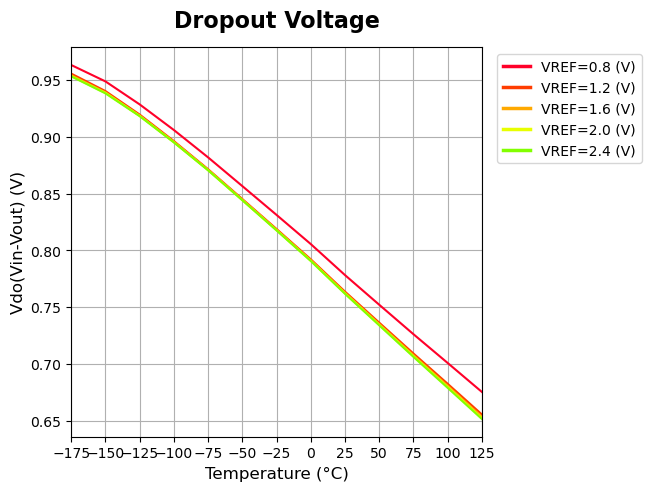

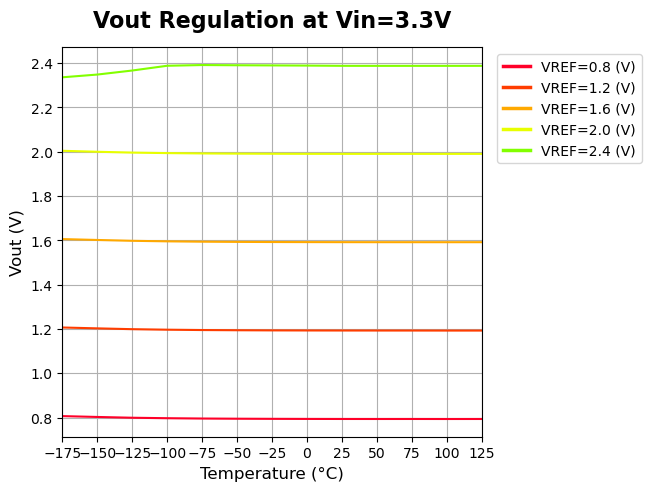

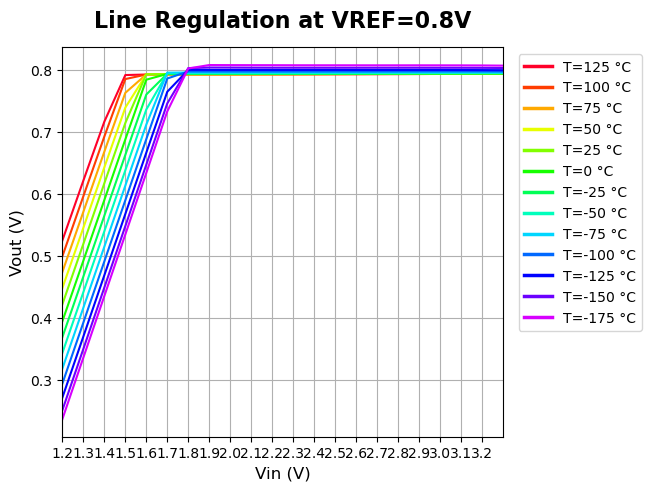

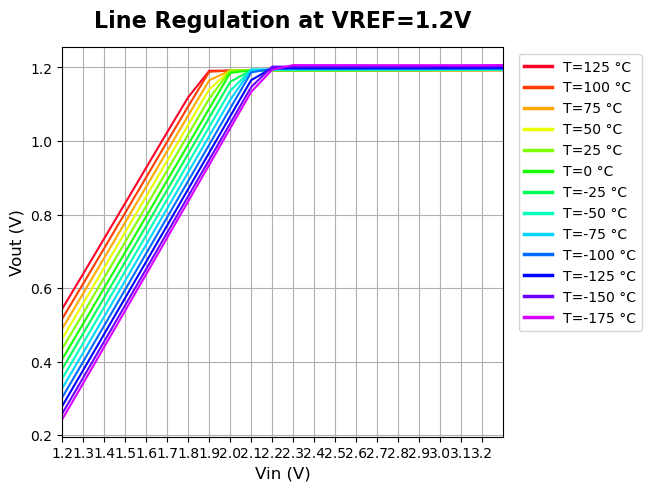

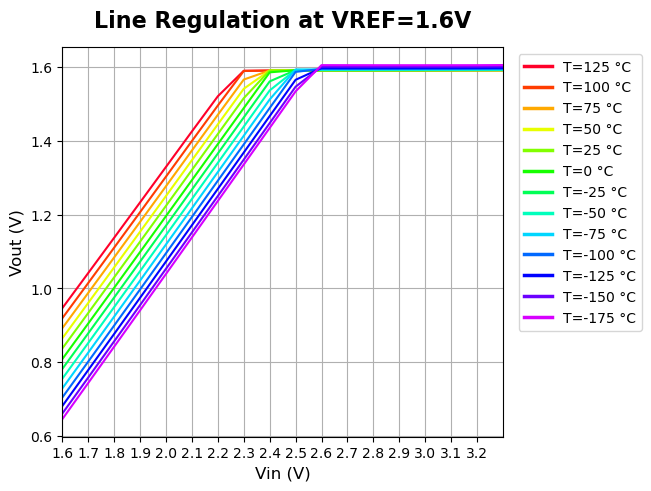

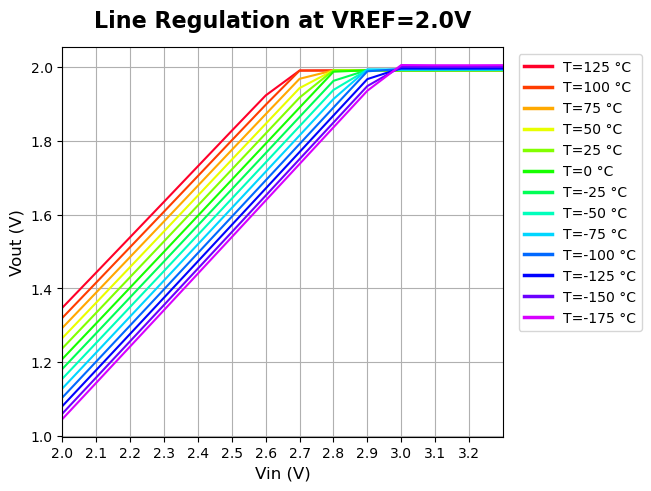

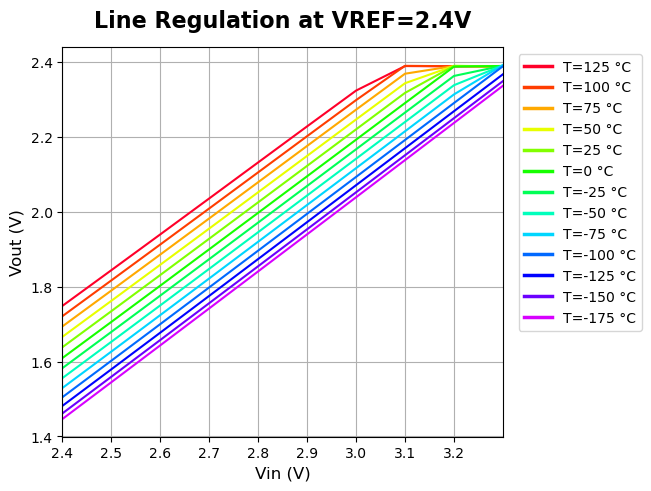

In [ ]:
# Create directory
DATE="NPN_LVR_Results/"+str(date.today())     # Create a directory with the date. If the directory already exists, it won't raise an error due to exist_ok=True
os.makedirs(DATE, exist_ok=True)
i=1
DUT= str(DATE)+"/DUT_"+str(i)
while os.path.isdir(DUT) == True and len(os.listdir(DUT)) != 0 :               # Keeps track of the number of tests done today and checks if the folder is empty
    DUT= str(DATE)+"/DUT_"+str(i)                
    i=i+1
os.makedirs(DUT, exist_ok=True)                 # Create another directory for test date for this test



################## Initial creation and format of overall curves ##################
# Create a color map for the plots
cm=plt.get_cmap('gist_rainbow')

# Create a figure for the overall dropout voltage plot
DVfig, DVplot = plt.subplots(layout='constrained')
DVplot.set_title('Dropout Voltage', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
DVplot.set_xlabel('Temperature (°C)', fontdict={'fontsize': 12})
DVplot.set_ylabel('Vdo(Vin-Vout) (V)', fontdict={'fontsize': 12})
#Vplot.set_yticks(np.arange(0, 1.3, 0.1))
DVplot.set_xticks(np.arange(-175, 150, 25))
DVplot.tick_params(axis='both', which='major', labelsize=10)
DVplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
DVplot.set_xlim(-175, 125)
#DVplot.set_ylim(-175, 125)
DVplot.grid()

# Create a figure for the overall vout regulation plot
VRfig, VRplot = plt.subplots(layout='constrained')
VRplot.set_title('Vout Regulation at Vin=3.3V', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
VRplot.set_xlabel('Temperature (°C)', fontdict={'fontsize': 12})
VRplot.set_ylabel('Vout (V)', fontdict={'fontsize': 12})
#VRplot.set_yticks(np.arange(0, 1.3, 0.1))
VRplot.set_xticks(np.arange(-175, 150, 25))
VRplot.tick_params(axis='both', which='major', labelsize=10)
VRplot.set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
VRplot.set_xlim(-175, 125)
#VRplot.set_ylim(-175, 125)
VRplot.grid()

LRplot = defaultdict(list)
LRfig = defaultdict(list)
# Create figures for the overall line regulation plots for each VREF
for VREF in VREFlist:
    LRfig[VREF], LRplot[VREF] = plt.subplots(layout='constrained')
    LRplot[VREF].set_title('Line Regulation at VREF='+str(VREF)+'V', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y = 1.03)
    LRplot[VREF].set_xlabel('Vin (V)', fontdict={'fontsize': 12})
    LRplot[VREF].set_ylabel('Vout (V)', fontdict={'fontsize': 12})
    #LRplot[VREF].set_yticks(np.arange(0, 3.3, 0.1))
    if VIN_MIN < VREF*10:                                   # Checks if the VIN_MIN value set in the first code block is less than VREF
        new_MIN = VREF*10 - 1                               # If yes: set the new minimum to be VREF instead of VIN_MIN
    else: new_MIN = VIN_MIN
    LRplot[VREF].set_xticks(np.arange((new_MIN+1)/10, 3.3, 0.1))
    LRplot[VREF].tick_params(axis='both', which='major', labelsize=10)
    LRplot[VREF].set_prop_cycle ('color', [cm(1.*i/len(TEMPlist)) for i in range(len(TEMPlist))])
    LRplot[VREF].set_xlim((new_MIN+1)/10, 3.3)
    #LRplot[VREF].set_ylim(0, 1.2)
    LRplot[VREF].grid()

#TURN ON DEVICE HERE
Chamber_INIT()
SMU_INIT()
MMs_INIT()

turn_on()




VDOdict = defaultdict(list)
VOUTregdict = defaultdict(list)
for TEMP in TEMPlist:
    local=str(DUT)+"/TEMP_"+str(TEMP)                           # The temperature of the experiment gets set as the sub directory name
    os.makedirs(local, exist_ok=True)                           # Create a directory with the given name. If the directory already exists, it won't raise an error due to exist_ok=True
    
    CHAMBER.write("WAIT=30")                                    # Resets the wait time of the temp chamber to 30 minutes so it doesn't time out mid test
    CHAMBER.write("SET=" + str(TEMP))
    # TODO: There is probably a better way to check for temperature settling and do wait time
    while (CHAMBER.query("STATUS?")[3] == 'N'):                 # Checks if the temperature chamber has arrived at TEMP yet or not
        time.sleep(15)
        print(CHAMBER.query("STATUS?"))  
    print(CHAMBER.query("STATUS?"))
    time.sleep(300)                                              # Soak time

    VDOlist, VOUTreglist = VREF_Sweep(local, TEMP, LRplot)                        # This calls the function definition that does everything within each VREF!!!
    for i, VREF in enumerate(VREFlist):
        VDOdict[VREF].append(VDOlist[i])
        VOUTregdict[VREF].append(VOUTreglist[i])
   
    for VREF in VREFlist:
        for line in LRplot[VREF].legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
            line.set_linewidth(2.5)
        LRfig[VREF].savefig(os.path.join(local, "Line_Regulation_"+str(VREF)+"V.png"))

for VREF in VREFlist:
    DVplot.plot(TEMPlist, VDOdict[VREF], label="VREF=" + str(VREF) + " (V)")
    VRplot.plot(TEMPlist, VOUTregdict[VREF], label="VREF=" + str(VREF) + " (V)")

for line in DVplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
for line in VRplot.legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
    line.set_linewidth(2.5)
DVfig.savefig(os.path.join(DUT, "Dropout_Voltage.png"))
VRfig.savefig(os.path.join(DUT, "Voltage_Regulation.png"))
for VREF in VREFlist:
    for line in LRplot[VREF].legend(bbox_to_anchor=(1.02, 1), loc='upper left').get_lines():
        line.set_linewidth(2.5)
    LRfig[VREF].savefig(os.path.join(DUT, "Line_Regulation_"+str(VREF)+"V.png"))


###############################################################
####################### Cold Start Test #######################
###############################################################

# After temperature testing is complete, turn off the source meters
turn_off()
CHAMBER.write("WAIT=30")                                        # Reset wait time so that it doesn't time out
time.sleep(900)                                                 # Wait 15 minutes for device to cool down
CHAMBER.write("WAIT=30")                                        # Same as above (TODO: There is probably a better way to do this)


#TURN ON DEVICE HERE
turn_on()
time.sleep(600)                 # Let the devices warm up again. Then run another measurement

CHAMBER.write("WAIT=30") 
local=str(DUT)+"/TEMP_-175C_Cold_Start"
os.makedirs(local, exist_ok=True)

VREF_Sweep(local, TEMP, LRplot)

##################### Shut Down Procedure #####################
turn_off()
CHAMBER.write("SET=30")                             # Sets the temperature back to room temp once test is complete                  
while (CHAMBER.query("STATUS?")[3] == 'N'):         # Checks if chamber has arrived at room temp
    time.sleep(15)
CHAMBER.write("STOP")                               # Once chamber is at room temp, chamber stops operation